# Hand Gesture Decoder

## Table of Content
0. [Import Dependencies](#install)
1. [Hands Detection using MediaPipe](#detection) 
2. [Feature Extraction](#feature-extraction) 
    1. [Write Columns Head in CSV File](#csv-header)
    2. [Extract Features of Assigned Class](#save-coordinates)
3. [Train Custom Model Using Scikit Learn](#model)
    1. [Load and Preprocess Input Data](#load-input)
    2. [Train A MLP Model](#training)
    3. [Evaluate and Serialize Model](#evaluate)
4. [Real-time Detections with Model](#real-time-detection)

## 0. Import Dependencies <a id="install"></a>

In [1]:
from mediapipe import solutions as mp
import cv2
import time
import os
import csv
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

## 1. Hands Detection using MediaPipe <a id="detection"></a>

To connect your phone camera:
- Install `DroidCam` App on your phone and `DroidCam Client` on your laptop. 
- Put the IP address in the `cv2.VideoCapture()` below.
- Or use other phone camera IP service provider.

In [2]:
# Using phone camera ip with DroidCam
# Webcam is 0
cap = cv2.VideoCapture("http://192.168.100.6:4747/mjpegfeed?640x480")
pTime = 0

with mp.hands.Hands(max_num_hands=1, min_detection_confidence=0.5, min_tracking_confidence=0.5) as hands:

    while True:
        success, frame = cap.read()
        
        if not success:
            break

        # Recolor feed
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        # Make detections
        results = hands.process(image)

        if results.multi_hand_landmarks:
            for hand_landmark in results.multi_hand_landmarks:
                
                # Draw hand landmarks
                mp.drawing_utils.draw_landmarks(image, hand_landmark, mp.hands.HAND_CONNECTIONS)
                
        
        # Display framerate
        cTime = time.time()
        fps = 1/(cTime-pTime+0.01)
        pTime = cTime
        cv2.putText(image, f"FPS: {int(fps)}", (500, 50), cv2.FONT_HERSHEY_PLAIN,
                    2, (255, 0, 0), 2)
    
        # Recolor for rendering
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        cv2.imshow("Hand detection", image)

        # Press "q" to exit
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

cap.release()
cv2.destroyAllWindows()

## 2. Feature Extraction <a id="feature-extraction"></a>

### Write Columns Head in CSV File <a id="csv-header"></a>

In [3]:
mp.hands.Hands??

In [4]:
num_coords = len(results.multi_hand_landmarks[0].landmark) 
num_coords

21

In [5]:
landmarks = ['class']
for val in range(1, num_coords+1):
    landmarks += ['x{}'.format(val), 'y{}'.format(val),
                  'z{}'.format(val), 'v{}'.format(val)]

In [6]:
if not os.path.exists("data"):
    os.mkdir("data")

with open("data/hand_gesture_coords.csv", mode="w", newline="" ) as f:
    csv_writer = csv.writer(f, delimiter=",", quotechar='"',quoting=csv.QUOTE_MINIMAL)
    csv_writer.writerow(landmarks)

### Extract Features of Assigned Class <a id="save-coordinates"></a>

In [11]:
class_name = "rock"

In [12]:
cap = cv2.VideoCapture("http://192.168.100.6:4747/mjpegfeed?640x480")

with mp.hands.Hands(max_num_hands=1, min_detection_confidence=0.5, min_tracking_confidence=0.5) as hands:

    while True:
        success, frame = cap.read()
        
        if not success:
            break

        # Recolor feed
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # Make detections
        results = hands.process(image)

        if results.multi_hand_landmarks:
            for hand_landmark in results.multi_hand_landmarks:
                
                # Draw hand landmarks
                mp.drawing_utils.draw_landmarks(image, hand_landmark, mp.hands.HAND_CONNECTIONS)
                
                hand = hand_landmark.landmark
                row = list(np.array([[landmark.x, landmark.y, landmark.z, landmark.visibility] 
                                          for landmark in hand]).flatten())
                
                # Append class name
                row.insert(0, class_name)
            
                # Export to CVS
                with open("data/hand_gesture_coords.csv", mode="a", newline="" ) as f:
                    csv_writer = csv.writer(f, delimiter=",", quotechar='"',quoting=csv.QUOTE_MINIMAL)
                    csv_writer.writerow(row)  
    
        # Recolor for rendering
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        cv2.imshow("Hand detection", image)

        # Press "q" to exit
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

cap.release()
cv2.destroyAllWindows()

## 3. Train Nueral Network Using Tensorflow <a id="model"></a>

### Load and Preprocess Input Data <a id="load-input"></a>

In [13]:
df = pd.read_csv("data/hand_gesture_coords.csv")
df

,class,x1,y1,z1,v1,x2,y2,z2,v2,x3,...,z19,v19,x20,y20,z20,v20,x21,y21,z21,v21
0,rock,0.360218,0.253137,-0.000017,0.0,0.379509,0.241325,0.058762,0.0,0.382359,...,0.124409,0.0,0.355370,0.159405,0.139080,0.0,0.356882,0.169766,0.148291,0.0
1,rock,0.361964,0.244486,-0.000005,0.0,0.382861,0.224510,0.050432,0.0,0.382558,...,0.125941,0.0,0.351107,0.190163,0.127852,0.0,0.353121,0.196690,0.128456,0.0
2,rock,0.211007,0.918127,0.000108,0.0,0.362073,0.977197,-0.075589,0.0,0.482378,...,-0.035797,0.0,0.367198,0.499457,-0.055575,0.0,0.373483,0.429025,-0.065644,0.0
3,rock,0.245864,0.909729,0.000035,0.0,0.218882,0.817402,-0.070855,0.0,0.222297,...,-0.186318,0.0,0.541781,0.762244,-0.201499,0.0,0.575129,0.691552,-0.229376,0.0
4,rock,0.488198,0.279233,0.000004,0.0,0.487766,0.242634,0.044318,0.0,0.487160,...,0.066686,0.0,0.499824,0.187962,0.074266,0.0,0.500655,0.202408,0.071662,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
855,seven,0.489749,0.821794,-0.000122,0.0,0.589618,0.778749,-0.069837,0.0,0.676070,...,-0.095493,0.0,0.409864,0.568320,-0.114572,0.0,0.425073,0.622769,-0.095460,0.0
856,seven,0.502322,0.822393,-0.000105,0.0,0.601376,0.781015,-0.067944,0.0,0.689164,...,-0.097281,0.0,0.420532,0.557798,-0.113069,0.0,0.434777,0.612906,-0.090801,0.0
857,seven,0.511157,0.821601,-0.000115,0.0,0.609224,0.782972,-0.069150,0.0,0.697867,...,-0.091248,0.0,0.429505,0.554195,-0.107579,0.0,0.444594,0.607738,-0.083771,0.0
858,seven,0.520130,0.821648,-0.000152,0.0,0.617137,0.785015,-0.071595,0.0,0.708056,...,-0.104248,0.0,0.439290,0.556390,-0.119537,0.0,0.453563,0.614814,-0.095432,0.0


In [14]:
# Split into input and output columns
X = df.drop("class", axis=1)
y = df["class"]

# Ensure all data are floating point values
X = X.astype('float32')

# Encode strings to integer
le = LabelEncoder()
y = le.fit_transform(y)
np.save("data/hand_geture_classes.npy", le.classes_)

In [15]:
# Split into train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=47)

# Determine the number of input features
n_features = X_train.shape[1]

# Determine the number or classes
n_class = len(np.unique(y_train))

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(688, 84) (172, 84) (688,) (172,)


### Train A MLP Model <a id="training"></a>

In [16]:
# Define a model with the sequential api
model = Sequential()
model.add(Dense(10, activation='relu', kernel_initializer='he_normal', input_shape=(n_features,)))
model.add(Dense(10, activation='relu', kernel_initializer='he_normal'))
model.add(Dense(n_class, activation='softmax'))

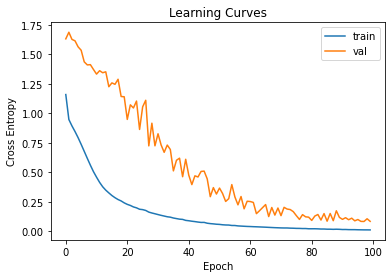

In [17]:
# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Fit the model
history = model.fit(X, y, epochs=100, batch_size=32, verbose=0, validation_split=0.2)

# Plot learning curves
plt.title('Learning Curves')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

### Evaluate and Serialize Model <a id="evaluate"></a>

In [18]:
# Evaluate the model
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print('Test Accuracy: %.3f' % acc)

# Make a prediction
row = np.random.randn(1, n_features)
yhat = model.predict([row])
print('Predicted: %s (class=%d | %s)' % (yhat, np.argmax(yhat), list(le.inverse_transform([np.argmax(yhat)]))[0]))

Test Accuracy: 1.000
Predicted: [[8.76693547e-01 1.23298906e-01 7.49807305e-06]] (class=0 | ok)


In [19]:
if not os.path.exists("generated_model"):
    os.mkdir("generated_model")
    
# Save model to file
model.save("generated_model/hand_gesture_model.h5")

## 4. Real-time Detections with Model <a id="real-time-detection"></a>

In [20]:
# Load the model from file
model_inference = load_model("generated_model/hand_gesture_model.h5")

In [21]:
# Load the class names
le = LabelEncoder()
le.classes_ = np.load("data/hand_geture_classes.npy", allow_pickle=True)

In [22]:
cap = cv2.VideoCapture("http://192.168.100.6:4747/mjpegfeed?640x480")
pTime = 0

with mp.hands.Hands(max_num_hands=1, min_detection_confidence=0.5, min_tracking_confidence=0.5) as hands:

    while True:
        success, frame = cap.read()
        
        if not success:
            break

        # Recolor feed
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # Make detections
        results = hands.process(image)
        
        if results.multi_hand_landmarks:
            for hand_landmark in results.multi_hand_landmarks:
                
                # Draw hand landmarks
                mp.drawing_utils.draw_landmarks(image, hand_landmark, mp.hands.HAND_CONNECTIONS)
                
                hand = hand_landmark.landmark
                row = np.array([[landmark.x, landmark.y, landmark.z, landmark.visibility] 
                                          for landmark in hand]).flatten()
                      
                # Predict using inference model
                pred = model_inference.predict(row.reshape(1, -1))
                class_name = list(le.inverse_transform([np.argmax(pred)]))[0]
                prob = np.max(pred).round(2)
                print(class_name, prob)
        
                # Display result 
                cv2.rectangle(image, (0,0), (250,60), (245, 117, 16), -1)
                cv2.putText(image, "CLASS", (95,12), cv2.FONT_HERSHEY_SIMPLEX,
                           0.5, (0,0,0), 1, cv2.LINE_AA)
                cv2.putText(image, class_name, (90,40), cv2.FONT_HERSHEY_SIMPLEX,
                           1, (255, 255, 255), 2, cv2.LINE_AA)
                cv2.putText(image, "PROB", (15,12), cv2.FONT_HERSHEY_SIMPLEX,
                           0.5, (0,0,0), 1, cv2.LINE_AA)
                cv2.putText(image, str(prob), (10,40), cv2.FONT_HERSHEY_SIMPLEX,
                           1, (255, 255, 255), 2, cv2.LINE_AA)
        
                # Display framerate
                cTime = time.time()
                fps = 1/(cTime-pTime)
                pTime = cTime
                cv2.putText(image, f"FPS: {int(fps)}", (500, 50), cv2.FONT_HERSHEY_PLAIN,
                            2, (255, 0, 0), 2)
    
        # Recolor for rendering
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        cv2.imshow("Hand detection", image)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

cap.release()
cv2.destroyAllWindows()

seven 0.79
seven 0.99
seven 0.99
rock 0.78
rock 0.97
rock 0.97
rock 0.98
rock 0.98
rock 0.98
rock 0.98
rock 0.99
rock 0.99
rock 0.99
rock 0.99
rock 0.99
rock 0.99
rock 0.99
rock 0.99
rock 0.99
rock 0.99
rock 0.99
rock 0.99
rock 0.99
rock 0.99
rock 0.99
rock 0.99
rock 0.99
rock 0.99
rock 0.99
rock 0.99
rock 0.99
rock 0.99
rock 0.99
rock 0.99
rock 0.99
rock 0.99
rock 0.99
rock 0.99
rock 0.99
rock 0.99
rock 0.99
rock 0.99
rock 0.99
rock 0.98
rock 0.89
rock 0.55
seven 0.6
seven 0.94
seven 0.98
seven 0.98
seven 0.99
seven 0.99
seven 0.99
seven 0.99
seven 0.99
seven 0.99
seven 0.99
seven 0.99
seven 0.99
seven 0.99
seven 0.99
seven 0.99
seven 0.99
seven 0.99
seven 0.99
seven 0.99
seven 0.99
seven 0.99
seven 0.99
seven 0.99
seven 0.99
seven 0.99
seven 0.99
seven 0.99
seven 0.99
seven 0.99
seven 0.99
seven 0.99
seven 0.99
seven 0.99
seven 0.99
seven 0.99
seven 0.99
seven 0.99
seven 0.99
seven 0.99
seven 0.99
seven 0.99
seven 0.99
seven 0.99
seven 0.99
seven 0.99
seven 0.99
seven 0.99
seven 0.99